In [1]:
import numpy as np
import torch 
from distributions import *
from utils import *
from copy import deepcopy
from tqdm import tqdm
plot_setting()
seed = 1

ModuleNotFoundError: No module named 'distributions'

In [3]:
from torch.distributions.multivariate_normal import MultivariateNormal

# __all__ = ["get_sampler"]

class mvn(MultivariateNormal):
    """
    rewrite the torch mvn distribution to incorporate pdf
    """

    def __init__(self, loc, cov, validate_args=None):
        super().__init__(loc, covariance_matrix=cov, validate_args=validate_args)
    
    def pdf(self, value):
        log_pdf = self.log_prob(value)
        return torch.exp(log_pdf)


def get_sampler(mu, cov, option):
    """ 
    input: 
        option: sampler options 
    
    output: 
        torch.distributions.distribution.Distribution Object
    
        available functions:  
            output.cdf(value : tensor)
            output.sample(sample_shape : shape) -> tensor with corresponding shape
            output.sample_n(n : sample_size) -> (n,)
            output.log_prob(value : tensor) -> 

    """
    if option=="mvn":
        return mvn(mu, cov)



def input(mu, cov, option):
    """ 
    input:
        option: input distribution type

    output:
        sampler object 

    """
    return get_sampler(mu, cov, option)

def true_map(locs, covs, heights, option='mvn'):
    """ 
    analytical mapping from input space to output QoI
    ideally some functions with several spikes in the tail region

    input:
        locs: center of the spikes, (m,d)
            m = number of spikes
            d = dimension of the input space
        vars: parameter that controls the shape of the spikes, (m,d,d)
        heights: possible scaling factor to scale the spike, (m,)
        option: type of spike function
            default='mvn' : multivariate normal
    
    output:
        mapping: true input-output map
            input: values, torch.Tensor, (n,d)
                   n: number of samples, d: dimension
    """
    if not isinstance(locs, torch.Tensor):
        locs = torch.Tensor(locs)
    m,d = locs.size()
    if not isinstance(covs, torch.Tensor):
        covs = torch.Tensor(covs)

    samplers = []
    for i in range(m):
        loc = locs[i,:]
        cov = covs[i,:,:]
        samplers.append(get_sampler(loc, cov, option))
    
    def mapping(values):
        n = values.size(dim=0)
        res = torch.zeros(n)
        for i,s in enumerate(samplers):
            h = heights[i]
            res += h * s.pdf(values)
        
        return res
    
    return mapping

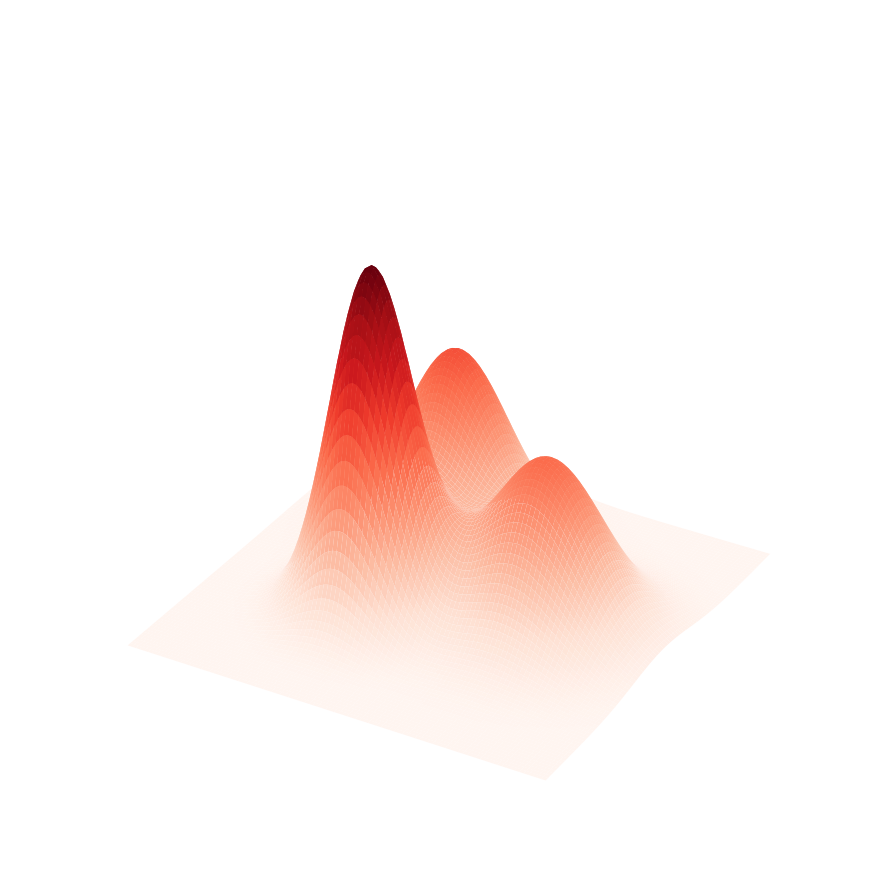

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# dimension of the problem
d = 2 

# grid points
N = 100
X1, X2 = torch.meshgrid(torch.linspace(-8,8, N), \
                              torch.linspace(-8, 8, N), indexing='ij')
GRIDS = torch.cat((X1.reshape(-1,1),X2.reshape(-1,1)), dim=1)

# define output map
locs2 = [
    [3.5,0],
    [-2,-2],
    [2,-2],
    [-2,3.5]
]
vars = np.asarray([
    4, 2, 3, 3.5
])
covs2 = np.asarray([
    torch.eye(d) * var for var in vars
])
# covs = torch.from_numpy(covs)
heights2 = torch.Tensor([
    1., 1., 0,1.
])

mapping2 = true_map(locs2, covs2, heights2)
OUT2 = mapping2(GRIDS)

fig = plt.figure(figsize = (6,6), dpi=150)
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X1.numpy(),X2.numpy(),OUT2.reshape(N,N).numpy()/3,cmap="Reds",linewidth=0, rcount=400, ccount=400)
ax.set_facecolor('white')
ax.axis('off')
plt.tight_layout()
# plt.savefig("./target.png")